# Classifying images of COVID-19, Normal, ViralPneumonia Using ResNet34

In [55]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
#from mlxtend.plotting import plot_confusion_matrix
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt


In [56]:
print (torch.__version__)
print(torchvision.__version__)

1.9.1
0.10.1


# Set Seaborn style.

In [57]:
%matplotlib inline
sns.set_style('darkgrid')

In [58]:
data_dir ='./ProcessedGANImages-Dataset'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'train']
['Covid19', 'Normal', 'ViralPneumonia']


In [59]:
covid19_files = os.listdir(data_dir + "/train/Covid19")
print('No. of training examples for Covid19:', len(covid19_files))
print(covid19_files[:5])

No. of training examples for Covid19: 4000
['Epoch-1521-fake_images4.png', 'Epoch-1522-fake_images1.png', 'Epoch-1522-fake_images4.png', 'Epoch-1522-fake_images5.png', 'Epoch-1523-fake_images0.png']


In [60]:
normal_files = os.listdir(data_dir + "/train/Normal")
print("No. of test examples for Lung Opacity:", len(normal_files))
print(normal_files[:5])

No. of test examples for Lung Opacity: 4000
['Epoch-1023-fake_images4.png', 'Epoch-1023-fake_images5.png', 'Epoch-1024-fake_images0.png', 'Epoch-1024-fake_images1.png', 'Epoch-1024-fake_images2.png']


In [61]:
viral_pneumonia_files = os.listdir(data_dir + "/train/ViralPneumonia")
print("No. of test examples for Viral pneumonia:", len(viral_pneumonia_files))
print(viral_pneumonia_files[:5])

No. of test examples for Viral pneumonia: 4000
['Epoch-1179-fake_images5.png', 'Epoch-1180-fake_images0.png', 'Epoch-1180-fake_images1.png', 'Epoch-1180-fake_images2.png', 'Epoch-1180-fake_images3.png']


# Creating training set

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. Source: https://pytorch.org/vision/stable/models.html

In [62]:
img_size = 224
train_dataset = ImageFolder(data_dir+'/train', transform=tt.Compose
                      ([tt.ToTensor(), 
                        tt.Grayscale(num_output_channels=3), 
                        tt.Resize((224,224)), 
                        tt.RandomHorizontalFlip(),
                        #tt.RandomRotation(degrees=(-90, 90)),
                        tt.Pad(8, padding_mode='reflect'),
                        tt.RandomCrop(img_size),
                        #tt.Normalize(mean=(0.5157), std=(0.2546))
                        #tt.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                        tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                       ]
                      ))

# Exploring data set

In [63]:
len(train_dataset)

12000

In [64]:
train_dataset.classes

['Covid19', 'Normal', 'ViralPneumonia']

In [65]:
# The list of classes is stored in the `.classes` property of the dataset. 
#The numeric label for each element corresponds to index of the element's label in the list of classes.
train_dataset.class_to_idx 

{'Covid19': 0, 'Normal': 1, 'ViralPneumonia': 2}

# Shape and Label of random samples

In [66]:
img, label = train_dataset[0]
print(img.shape, label)

torch.min(img), torch.max(img)

torch.Size([3, 224, 224]) 0


(tensor(-0.9913), tensor(0.9928))

In [67]:
img, label = train_dataset[1200]
print(img.shape, label)

torch.min(img), torch.max(img)

torch.Size([3, 224, 224]) 0


(tensor(-0.9756), tensor(0.9998))

# View random samples

In [68]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [69]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Covid19 (0)


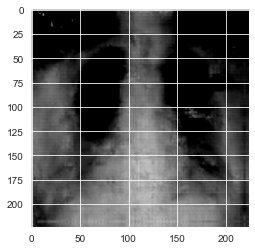

In [70]:
show_example(*train_dataset[671])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Covid19 (0)


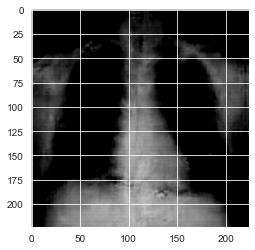

In [71]:
show_example(*train_dataset[670])

# Get Train and Validation Samples

In [72]:
random_seed = 42
torch.manual_seed(random_seed);

In [73]:
val_size = int(0.2*len(train_dataset))
#print(val_size)
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(9600, 2400)

We can now create data loaders for training and validation, to load the data in batches

In [74]:
batch_size=50

In [75]:
train_dl= DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

We can look at batches of images from the dataset using the make_grid method from torchvision. Each time the following code is run, we get a different bach, since the sampler shuffles the indices before creating batches.

# Normalized Images

In [76]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=10).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


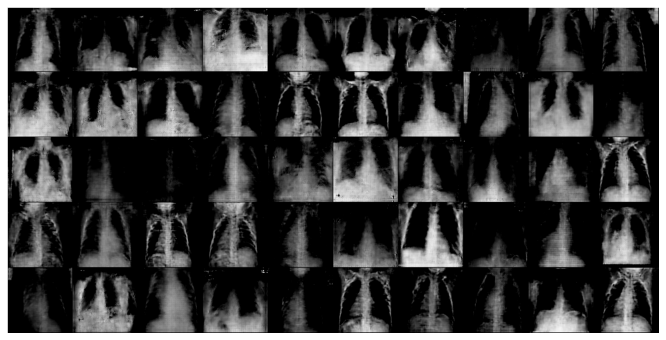

In [77]:
show_batch(train_dl)

# Denormalized Images

In [78]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 1, 1, 1)
    stds = torch.tensor(stds).reshape(1, 1, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        #denorm_images = denormalize(images, 0.5157,0.2546)
        denorm_images = denormalize(images, 0.5,0.5)
        ax.imshow(make_grid(denorm_images[:64], nrow=10).permute(1, 2, 0).clamp(0,1))
        break

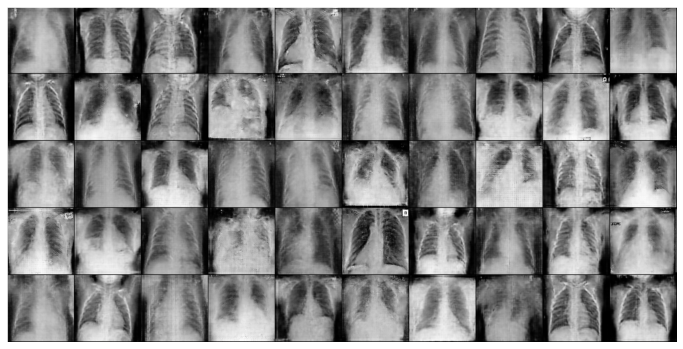

In [79]:
show_batch(train_dl)

# Classes Distribution in dataset

In [ ]:
idx2class = {v: k for k, v in train_dataset.class_to_idx.items()}

def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)

plt.figure(figsize=(15,8))
plot_from_dict(get_class_distribution(train_dataset), plot_title="Entire Dataset (before train/val/test split)")

## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)


In [80]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f},train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))
        
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'test_loss': loss.detach(), 'test_acc': acc , 'test_preds':out, 'test_actual_labels':labels}
        
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean() # Combine accuracies 
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}    
        
        


# Use a pretrained model

In [81]:
from torchvision import models

class CovidResNetModel(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

## GPU Utilities and Training Loop

In [82]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [83]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad()
def evaluate_test(model, test_loader):
    model.eval()
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_acc = []
        for batch in tqdm(train_loader):
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_acc = []
        lrs = []
        for batch in tqdm(train_loader):
            loss,acc = model.training_step(batch)
            train_losses.append(loss)
            train_acc.append(acc)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_acc).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [84]:
device = get_default_device()
device

device(type='cuda')

In [85]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

## Finetuning the Pretrained Model

In [86]:
model = CovidResNetModel(len(train_dataset.classes))
to_device(model, device);

In [87]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3458374738693237, 'val_acc': 0.3424999713897705}]

In [130]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [131]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00758, train_loss: 0.0100,train_acc: 0.9965, val_loss: 0.1417, val_acc: 0.9479


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00950, train_loss: 0.0265,train_acc: 0.9918, val_loss: 0.0104, val_acc: 0.9971


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00611, train_loss: 0.0106,train_acc: 0.9972, val_loss: 0.0033, val_acc: 0.9996


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00188, train_loss: 0.0044,train_acc: 0.9986, val_loss: 0.0011, val_acc: 1.0000


  0%|          | 0/192 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00000, train_loss: 0.0017,train_acc: 0.9995, val_loss: 0.0003, val_acc: 1.0000
Wall time: 3min 15s


In [151]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            #'optimizer':optimizer.state_dict()
    
              
            }, 'ResNet34-Covid19.pt') 

In [152]:
checkpoint = torch.load('ResNet34-Covid19.pt')
model.load_state_dict(checkpoint['model_state_dict']) # Load  model
#optimizer.load_state_dict(checkpoint['optimizer']) # Load optimizer
previous_epochs = checkpoint['epoch']
print("Number of Epochs after training:",previous_epochs)

Number of Epochs after training: 5


# Graph of training and validation accuracy 

In [134]:
def plot_accuracies(history):
    train_accuracies = [x.get('train_acc') for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    plt.plot(train_accuracies, '-bx')
    plt.plot(val_accuracies, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');

In [94]:
print (history)

[{'val_loss': 1.3458374738693237, 'val_acc': 0.3424999713897705}, {'val_loss': 0.0064860060811042786, 'val_acc': 0.9995833039283752, 'train_loss': 0.04163125902414322, 'train_acc': 0.9860417246818542, 'lrs': [0.0003999999999999993, 0.0004000028577722456, 0.00040001143108558436, 0.00040002571992980157, 0.00040004572428788826, 0.0004000714441360232, 0.00040010287944357986, 0.00040014003017312637, 0.00040018289628042554, 0.00040023147771443834, 0.0004002857744173152, 0.00040034578632440303, 0.00040041151336424156, 0.0004004829554585705, 0.0004005601125223173, 0.000400642984463611, 0.0004007315711837701, 0.0004008258725773147, 0.00040092588853195277, 0.00040103161892859375, 0.0004011430636413401, 0.0004012602225374907, 0.0004013830954775373, 0.0004015116823151716, 0.00040164598289728175, 0.0004017859970639505, 0.00040193172464845703, 0.00040208316547728044, 0.0004022403193700893, 0.0004024031861397572, 0.00040257176559235254, 0.00040274605752714174, 0.0004029260617365877, 0.000403111778006

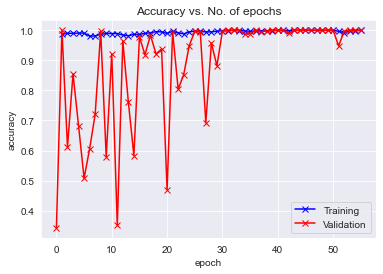

In [135]:
plot_accuracies(history)

# Graph of training and validation Loss

In [136]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

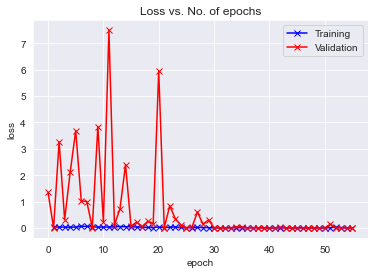

In [137]:
plot_losses(history)

# Testing with individual images

In [138]:
test_dataset = ImageFolder(data_dir+'/test', transform=tt.Compose
                      ([tt.ToTensor(), 
                        tt.Grayscale(num_output_channels=3), 
                        tt.Resize((224,224)), 
                        tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                       ]
                      ))

In [139]:
test_dataset.classes

['COVID19', 'NORMAL', 'VIRALPNEUMONIA']

In [140]:
test_dataset.classes[1]

'NORMAL'

In [141]:
len(test_dataset)

438

# Total count of each class in test dataset

In [142]:
import collections

arr=np.array(test_dataset.targets)

def CountFrequency(arr):
    return collections.Counter(arr)  

freq = CountFrequency(arr)


for (key, value) in freq.items():
        print (test_dataset.classes[key],":",key,  " -> ", value)

COVID19 : 0  ->  146
NORMAL : 1  ->  146
VIRALPNEUMONIA : 2  ->  146


Let's define a helper function predict_image, which returns the predicted label for a single image tensor.

In [143]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: COVID19 , Predicted: VIRALPNEUMONIA


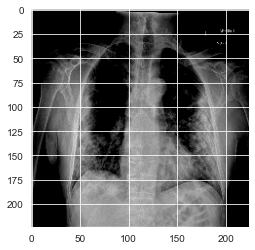

In [105]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: NORMAL , Predicted: COVID19


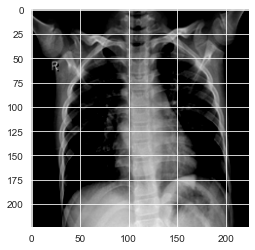

In [144]:
img, label = test_dataset[150]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: NORMAL , Predicted: COVID19


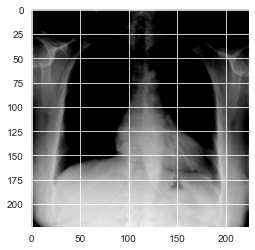

In [145]:
img, label = test_dataset[200]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: VIRALPNEUMONIA , Predicted: VIRALPNEUMONIA


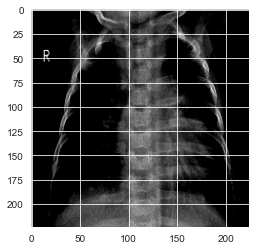

In [146]:
img, label = test_dataset[400]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: NORMAL , Predicted: COVID19


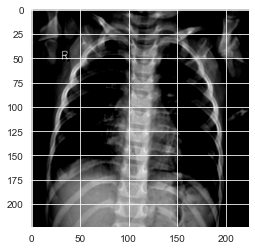

In [147]:
img, label = test_dataset[170]
plt.imshow(img.permute(1, 2, 0), cmap='gray')
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

# Testing with batch of images

In [148]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)

In [149]:
result = evaluate_test(model, test_loader)
print(result)

{'test_loss': 5.132206916809082, 'test_acc': 0.522947371006012}


# Build a function to get predictions for all test samples

In [112]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).cuda()
    all_test_labels = torch.tensor([]).cuda()
    for batch in loader:
        images, labels = batch
        
        all_test_labels = torch.cat(
            (all_test_labels, labels)
            ,dim=0
        )

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
        
    _, all_test_preds = torch.max(all_preds, dim=1)
        
        
    return all_test_preds, all_test_labels


In [113]:
def get_num_correct(test_preds,labels):
  return torch.tensor(torch.sum(test_preds == labels).item())

In [114]:
with torch.no_grad():
    all_test_preds,all_test_labels = get_all_preds(model, test_loader)
print("All Test Predictions:",all_test_preds)
print("All actual test labels:",all_test_labels)

All Test Predictions: tensor([2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0,
        0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

In [115]:
all_test_preds.shape

torch.Size([438])

In [116]:
all_test_labels.shape

torch.Size([438])

In [117]:
all_test_preds.type(torch.int32)

tensor([2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0,
        0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0,
        2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,

In [118]:
all_test_labels.type(torch.int32)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,

In [119]:
all_test_preds == all_test_labels

tensor([False, False, False,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False,  True, False, False, False, False,  True,
        False, False,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False, False,
        False,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True, False,
         True, False,  True,  True, False,  True, False,  True, False,  True,
        False, False,  True,  True,  True,  True,  True,  True, 

In [150]:
preds_correct = get_num_correct(all_test_preds, all_test_labels)
print('Total correct no of test predictions:', (preds_correct).item())
print('Test Accuracy:', (preds_correct / len(test_dataset)).item() * 100)

Total correct no of test predictions: 229
Test Accuracy: 52.28310227394104


# Plotting The Confusion Matrix

In [121]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

In [122]:
stacked = torch.stack(
(
    all_test_labels.type(torch.int32),all_test_preds.type(torch.int32)
),dim=1

)

In [123]:
stacked

tensor([[0, 2],
        [0, 2],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 2],
        [0, 2],
        [0, 2],
        [0, 2],
        [0, 0],
        [0, 2],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 0],
        [0, 2],
        [0, 0],
        [0, 0],
        [0, 2],
        

In [124]:
stacked[0].tolist()

[0, 2]

In [125]:
cmt = torch.zeros(3,3,dtype=torch.int32)
cmt

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int32)

In [126]:
for p in stacked:
    true_label,predicted_label = p.tolist()
    cmt[true_label,predicted_label] = cmt[true_label,predicted_label] + 1
cmt    

tensor([[111,   0,  35],
        [136,   0,  10],
        [ 28,   0, 118]], dtype=torch.int32)

In [127]:
cm = confusion_matrix(all_test_labels.cpu().numpy(),all_test_preds.cpu().numpy())
print(type(cm))
cm

<class 'numpy.ndarray'>


array([[111,   0,  35],
       [136,   0,  10],
       [ 28,   0, 118]], dtype=int64)

Confusion matrix, without normalization
[[111   0  35]
 [136   0  10]
 [ 28   0 118]]


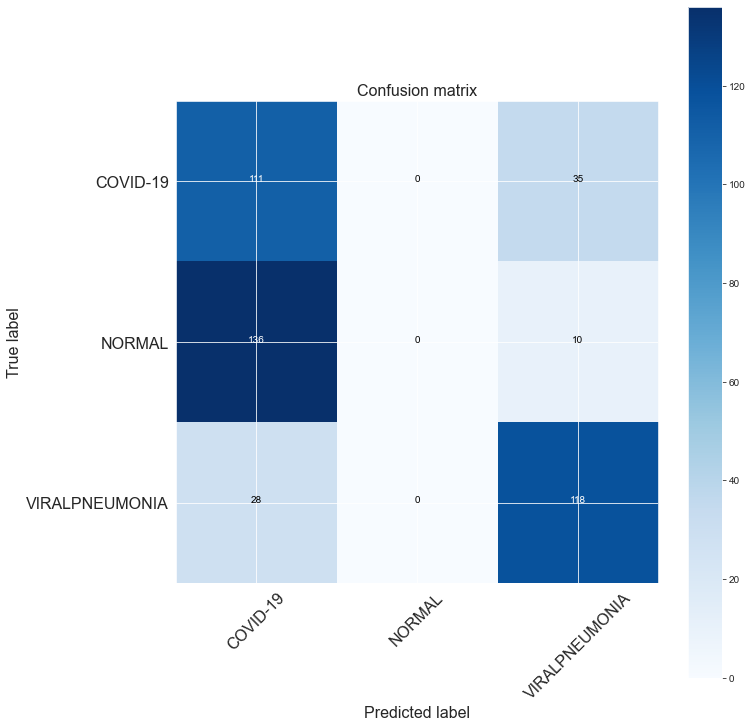

In [128]:
names = ('COVID-19', 'NORMAL','VIRALPNEUMONIA')
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,names)
plt.xticks(range(3), names, fontsize=16)
plt.yticks(range(3), names, fontsize=16)
plt.show()

## Training a model from scratch 

Let's repeat the training without using weights from the pretrained ResNet34 model.

In [ ]:
model2 = PetsModel(len(dataset.classes), pretrained=False)
to_device(model2, device);

In [ ]:
history2 = [evaluate(model2, valid_dl)]
history2

In [ ]:
%%time
history2 += fit_one_cycle(epochs, max_lr, model2, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

While the pretrained model reached an accuracy of 80% in less than 3 minutes, the model without pretrained weights could only reach an accuracy of 24%.